# **4.4 HyperParameter Tuning**

In [ ]:
import os
import itertools
import torch
import torch.optim as optim
from itertools import cycle
from datetime import datetime
import wandb
import random
import math

In [ ]:
!pip install --upgrade wandb


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 83.7 MB/s eta 0:00:00
  Attempting uninstall: wandb
    Found existing installation: wandb 0.18.7
    Uninstalling wandb-0.18.7:
      Successfully uninstalled wandb-0.18.7


In [ ]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## **Modified Class for loading a subset of the data**

In [ ]:
class UnpairedImageDataset(Dataset):
    def __init__(self, image_dir, transform=None, subset_size=300):
        self.image_dir = image_dir
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        if subset_size:
            self.image_paths = self.image_paths[:subset_size]  # Use only a subset of images
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Load Dataset with Subset Sampling
def load_data(data_dir, batch_size, subset_size=300):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Using 512x512 or 256x256 resolution
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    dataset = UnpairedImageDataset(data_dir, transform=transform, subset_size=subset_size)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)


## **Defining the Training Loop**

In [ ]:
# Training Function
def train_cycle_gan(generator_A2B, generator_B2A, discriminator_A, discriminator_B,
                    dataloader_A, dataloader_B, optimizer_G, optimizer_D,
                    loss_fn, epochs, device, checkpoint_dir="/content/drive/MyDrive/Pipeline_2/sweep_checkpoints"):
    """
    Train CycleGAN with WandB integration and unique checkpoints.
    """
    os.makedirs(checkpoint_dir, exist_ok=True)

    for epoch in range(epochs):
        epoch_generator_loss = 0.0
        epoch_discriminator_loss = 0.0
        num_batches = 0

        for real_A, real_B in zip(dataloader_A, cycle(dataloader_B)):
            num_batches += 1
            real_A, real_B = real_A.to(device), real_B.to(device)

            # ------------------------
            # Train Generators
            # ------------------------
            optimizer_G.zero_grad()

            fake_B = generator_A2B(real_A)
            reconstructed_A = generator_B2A(fake_B)
            fake_A = generator_B2A(real_B)
            reconstructed_B = generator_A2B(fake_A)

            identity_A = generator_B2A(real_A)
            identity_B = generator_A2B(real_B)

            loss_G_A2B = loss_fn.generator_loss(discriminator_B(fake_B), real_A, reconstructed_A, identity_B)
            loss_G_B2A = loss_fn.generator_loss(discriminator_A(fake_A), real_B, reconstructed_B, identity_A)
            loss_G = loss_G_A2B + loss_G_B2A
            loss_G.backward()
            optimizer_G.step()

            # ------------------------
            # Train Discriminators
            # ------------------------
            optimizer_D.zero_grad()

            fake_A_detached = fake_A.detach()
            fake_B_detached = fake_B.detach()

            loss_D_A = loss_fn.discriminator_loss(discriminator_A(real_A), discriminator_A(fake_A_detached))
            loss_D_B = loss_fn.discriminator_loss(discriminator_B(real_B), discriminator_B(fake_B_detached))

            loss_D = (loss_D_A + loss_D_B) / 2
            loss_D.backward()
            optimizer_D.step()

            epoch_generator_loss += loss_G.item()
            epoch_discriminator_loss += loss_D.item()

        avg_generator_loss = epoch_generator_loss / num_batches
        avg_discriminator_loss = epoch_discriminator_loss / num_batches

        print(f"Epoch [{epoch+1}/{epochs}], Generator Loss: {avg_generator_loss:.4f}, Discriminator Loss: {avg_discriminator_loss:.4f}")

        wandb.log({
            "epoch": epoch + 1,
            "generator_loss": avg_generator_loss,
            "discriminator_loss": avg_discriminator_loss,
        })

        # Save checkpoint for this run
        checkpoint_path = os.path.join(checkpoint_dir, f"epoch_{epoch+1}.pth")
        checkpoint = {
            "generator_A2B": generator_A2B.state_dict(),
            "generator_B2A": generator_B2A.state_dict(),
            "discriminator_A": discriminator_A.state_dict(),
            "discriminator_B": discriminator_B.state_dict(),
            "optimizer_G": optimizer_G.state_dict(),
            "optimizer_D": optimizer_D.state_dict(),
            "epoch": epoch,
        }
        torch.save(checkpoint, checkpoint_path)

# WandB Sweep Training Loop
def train_cycle_gan_model(data_A_dir, data_B_dir):
    """
    Train CycleGAN model with WandB Sweeps.
    """
    with wandb.init() as run:
        config = wandb.config

        # Load datasets with fixed subset size
        dataloader_A = load_data(data_A_dir, batch_size=config.batch_size)
        dataloader_B = load_data(data_B_dir, batch_size=config.batch_size)

        # Initialize models
        generator_A2B = Generator(3, 3).to(device)
        generator_B2A = Generator(3, 3).to(device)
        discriminator_A = Discriminator(3).to(device)
        discriminator_B = Discriminator(3).to(device)

        # Initialize loss function
        loss_fn = CycleGANLosses(lambda_cycle=config.lambda_cycle, lambda_identity=config.lambda_identity)

        # Optimizers
        optimizer_G = optim.Adam(itertools.chain(generator_A2B.parameters(), generator_B2A.parameters()),
                                 lr=config.generator_lr, betas=(0.5, 0.999))
        optimizer_D = optim.Adam(itertools.chain(discriminator_A.parameters(), discriminator_B.parameters()),
                                 lr=config.discriminator_lr, betas=(0.5, 0.999))

        # Unique checkpoint directory for each run
        run_name = datetime.now().strftime("%Y%m%d_%H%M%S")
        checkpoint_dir = os.path.join("/content/drive/MyDrive/Pipeline_2/sweep_checkpoints", f"run_{run_name}")

        # Train the CycleGAN model
        train_cycle_gan(generator_A2B, generator_B2A, discriminator_A, discriminator_B,
                        dataloader_A, dataloader_B, optimizer_G, optimizer_D,
                        loss_fn, config.epochs, device, checkpoint_dir)

# Sweep Configuration
sweep_config = {
    "method": "random",
    "metric": {
        "name": "generator_loss",
        "goal": "minimize"
    },
    "parameters": {
        "generator_lr": {"value": 0.0005},
        "discriminator_lr": {"value": 0.00005},
        "batch_size": {"value": 8},
        "epochs": {"value": 20},
        "lambda_cycle": {"values": [1.0, 5.0, 10]},
        "lambda_identity": {"values": [1.0, 5.0, 10]},
    }
}



In [ ]:
data_A_dir = "/content/drive/MyDrive/Pipeline_2/clustered_images/cluster_2"
data_B_dir = "/content/drive/MyDrive/Pipeline_2/clustered_images_VanGogh/cluster_4"

In [ ]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Initialize Sweep
sweep_id = wandb.sweep(sweep_config, project="cycle-gan")

# Run Sweep Agent
wandb.agent(sweep_id, function=lambda: train_cycle_gan_model(data_A_dir, data_B_dir))

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: 3rhyqge5
Sweep URL: https://wandb.ai/biasdrive-neuromatch/cycle-gan/sweeps/3rhyqge5


wandb: Agent Starting Run: vg058ctm with config:
wandb: 	batch_size: 8
wandb: 	discriminator_lr: 5e-05
wandb: 	epochs: 20
wandb: 	generator_lr: 0.0005
wandb: 	lambda_cycle: 10
wandb: 	lambda_identity: 10
wandb: Currently logged in as: rawan_khalifa (biasdrive-neuromatch). Use `wandb login --relogin` to force relogin


Epoch [1/20], Generator Loss: 17.9595, Discriminator Loss: 0.2037
Epoch [2/20], Generator Loss: 16.4207, Discriminator Loss: 0.1579
Epoch [3/20], Generator Loss: 15.6088, Discriminator Loss: 0.1317
Epoch [4/20], Generator Loss: 15.1673, Discriminator Loss: 0.1279
Epoch [5/20], Generator Loss: 14.9306, Discriminator Loss: 0.1193
Epoch [6/20], Generator Loss: 14.7100, Discriminator Loss: 0.1127
Epoch [7/20], Generator Loss: 14.5857, Discriminator Loss: 0.1130
Epoch [8/20], Generator Loss: 14.4819, Discriminator Loss: 0.1073
Epoch [9/20], Generator Loss: 14.4009, Discriminator Loss: 0.1020
Epoch [10/20], Generator Loss: 14.4378, Discriminator Loss: 0.0944
Epoch [11/20], Generator Loss: 14.3659, Discriminator Loss: 0.0969
Epoch [12/20], Generator Loss: 14.3210, Discriminator Loss: 0.0918
Epoch [13/20], Generator Loss: 14.2736, Discriminator Loss: 0.0832
Epoch [14/20], Generator Loss: 14.2645, Discriminator Loss: 0.0857
Epoch [15/20], Generator Loss: 14.2443, Discriminator Loss: 0.0771
Epoc

wandb: Agent Starting Run: cr9yv831 with config:
wandb: 	batch_size: 8
wandb: 	discriminator_lr: 5e-05
wandb: 	epochs: 20
wandb: 	generator_lr: 0.0005
wandb: 	lambda_cycle: 10
wandb: 	lambda_identity: 1


Epoch [1/20], Generator Loss: 9.6968, Discriminator Loss: 0.2041
Epoch [2/20], Generator Loss: 8.1253, Discriminator Loss: 0.1681
Epoch [3/20], Generator Loss: 7.3501, Discriminator Loss: 0.1588
Epoch [4/20], Generator Loss: 7.0247, Discriminator Loss: 0.1559
Epoch [5/20], Generator Loss: 6.7556, Discriminator Loss: 0.1488
Epoch [6/20], Generator Loss: 6.6067, Discriminator Loss: 0.1415
Epoch [7/20], Generator Loss: 6.5504, Discriminator Loss: 0.1353
Epoch [8/20], Generator Loss: 6.4190, Discriminator Loss: 0.1305
Epoch [9/20], Generator Loss: 6.3143, Discriminator Loss: 0.1377
Epoch [10/20], Generator Loss: 6.3399, Discriminator Loss: 0.1280
Epoch [11/20], Generator Loss: 6.2411, Discriminator Loss: 0.1206
Epoch [12/20], Generator Loss: 6.1248, Discriminator Loss: 0.1228
Epoch [13/20], Generator Loss: 6.0600, Discriminator Loss: 0.1230
Epoch [14/20], Generator Loss: 6.0283, Discriminator Loss: 0.1210
Epoch [15/20], Generator Loss: 5.9779, Discriminator Loss: 0.1214
Epoch [16/20], Gene

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u1b5uxj3 with config:
wandb: 	batch_size: 8
wandb: 	discriminator_lr: 5e-05
wandb: 	epochs: 20
wandb: 	generator_lr: 0.0005
wandb: 	lambda_cycle: 10
wandb: 	lambda_identity: 10


Epoch [1/20], Generator Loss: 17.9277, Discriminator Loss: 0.2042
Epoch [2/20], Generator Loss: 16.2370, Discriminator Loss: 0.1566
Epoch [3/20], Generator Loss: 15.3502, Discriminator Loss: 0.1390
Epoch [4/20], Generator Loss: 15.0480, Discriminator Loss: 0.1183
Epoch [5/20], Generator Loss: 14.9545, Discriminator Loss: 0.1110
Epoch [6/20], Generator Loss: 14.6937, Discriminator Loss: 0.1016
Epoch [7/20], Generator Loss: 14.5569, Discriminator Loss: 0.1005
Epoch [8/20], Generator Loss: 14.4994, Discriminator Loss: 0.0969
Epoch [9/20], Generator Loss: 14.3790, Discriminator Loss: 0.0968
Epoch [10/20], Generator Loss: 14.2870, Discriminator Loss: 0.0860
Epoch [11/20], Generator Loss: 14.1860, Discriminator Loss: 0.0909
Epoch [12/20], Generator Loss: 14.1267, Discriminator Loss: 0.0889
Epoch [13/20], Generator Loss: 14.1313, Discriminator Loss: 0.0894
Epoch [14/20], Generator Loss: 14.0883, Discriminator Loss: 0.0740
Epoch [15/20], Generator Loss: 14.1452, Discriminator Loss: 0.0689
Epoc

wandb: Agent Starting Run: zjagaa8q with config:
wandb: 	batch_size: 8
wandb: 	discriminator_lr: 5e-05
wandb: 	epochs: 20
wandb: 	generator_lr: 0.0005
wandb: 	lambda_cycle: 1
wandb: 	lambda_identity: 1


Epoch [1/20], Generator Loss: 2.3117, Discriminator Loss: 0.2267
Epoch [2/20], Generator Loss: 2.2425, Discriminator Loss: 0.2164
Epoch [3/20], Generator Loss: 2.2129, Discriminator Loss: 0.2108
Epoch [4/20], Generator Loss: 2.1955, Discriminator Loss: 0.2123
Epoch [5/20], Generator Loss: 2.1879, Discriminator Loss: 0.2046
Epoch [6/20], Generator Loss: 2.1782, Discriminator Loss: 0.2107
Epoch [7/20], Generator Loss: 2.1841, Discriminator Loss: 0.2033
Epoch [8/20], Generator Loss: 2.1943, Discriminator Loss: 0.2003
Epoch [9/20], Generator Loss: 2.1960, Discriminator Loss: 0.1956
Epoch [10/20], Generator Loss: 2.1846, Discriminator Loss: 0.1955
Epoch [11/20], Generator Loss: 2.2098, Discriminator Loss: 0.1921
Epoch [12/20], Generator Loss: 2.2191, Discriminator Loss: 0.1772
Epoch [13/20], Generator Loss: 2.2095, Discriminator Loss: 0.1818
Epoch [14/20], Generator Loss: 2.2503, Discriminator Loss: 0.1774
Epoch [15/20], Generator Loss: 2.2246, Discriminator Loss: 0.1787
Epoch [16/20], Gene

wandb: Agent Starting Run: xu1r5yp1 with config:
wandb: 	batch_size: 8
wandb: 	discriminator_lr: 5e-05
wandb: 	epochs: 20
wandb: 	generator_lr: 0.0005
wandb: 	lambda_cycle: 1
wandb: 	lambda_identity: 10


Epoch [1/20], Generator Loss: 10.3871, Discriminator Loss: 0.2109
Epoch [2/20], Generator Loss: 10.3011, Discriminator Loss: 0.1830
Epoch [3/20], Generator Loss: 10.1843, Discriminator Loss: 0.1798
Epoch [4/20], Generator Loss: 10.2164, Discriminator Loss: 0.1657
Epoch [5/20], Generator Loss: 10.2377, Discriminator Loss: 0.1533
Epoch [6/20], Generator Loss: 10.2370, Discriminator Loss: 0.1497
Epoch [7/20], Generator Loss: 10.2544, Discriminator Loss: 0.1325
Epoch [8/20], Generator Loss: 10.3399, Discriminator Loss: 0.1184
Epoch [9/20], Generator Loss: 10.3628, Discriminator Loss: 0.1195
Epoch [10/20], Generator Loss: 10.4822, Discriminator Loss: 0.1372
Epoch [11/20], Generator Loss: 10.4989, Discriminator Loss: 0.1100
Epoch [12/20], Generator Loss: 10.4445, Discriminator Loss: 0.0854
Epoch [13/20], Generator Loss: 10.4574, Discriminator Loss: 0.0788
Epoch [14/20], Generator Loss: 10.5013, Discriminator Loss: 0.0965
Epoch [15/20], Generator Loss: 10.5173, Discriminator Loss: 0.1174
Epoc

wandb: Agent Starting Run: fe3bfnaj with config:
wandb: 	batch_size: 8
wandb: 	discriminator_lr: 5e-05
wandb: 	epochs: 20
wandb: 	generator_lr: 0.0005
wandb: 	lambda_cycle: 10
wandb: 	lambda_identity: 5


Epoch [1/20], Generator Loss: 13.3857, Discriminator Loss: 0.2065
Epoch [2/20], Generator Loss: 12.0663, Discriminator Loss: 0.1449
Epoch [3/20], Generator Loss: 11.4945, Discriminator Loss: 0.1216
Epoch [4/20], Generator Loss: 10.9471, Discriminator Loss: 0.1054
Epoch [5/20], Generator Loss: 10.6953, Discriminator Loss: 0.0969
Epoch [6/20], Generator Loss: 10.5130, Discriminator Loss: 0.1110
Epoch [7/20], Generator Loss: 10.2494, Discriminator Loss: 0.1251
Epoch [8/20], Generator Loss: 10.0091, Discriminator Loss: 0.1174
Epoch [9/20], Generator Loss: 9.9804, Discriminator Loss: 0.1135
Epoch [10/20], Generator Loss: 9.8524, Discriminator Loss: 0.1143
Epoch [11/20], Generator Loss: 9.8392, Discriminator Loss: 0.1039
Epoch [12/20], Generator Loss: 9.7420, Discriminator Loss: 0.0973
Epoch [13/20], Generator Loss: 9.6221, Discriminator Loss: 0.0935
Epoch [14/20], Generator Loss: 9.5981, Discriminator Loss: 0.0902
Epoch [15/20], Generator Loss: 9.6575, Discriminator Loss: 0.0837
Epoch [16/2

wandb: Agent Starting Run: rnv84fmd with config:
wandb: 	batch_size: 8
wandb: 	discriminator_lr: 5e-05
wandb: 	epochs: 20
wandb: 	generator_lr: 0.0005
wandb: 	lambda_cycle: 5
wandb: 	lambda_identity: 10


Epoch [1/20], Generator Loss: 13.9209, Discriminator Loss: 0.2027
Epoch [2/20], Generator Loss: 13.4396, Discriminator Loss: 0.1758
Epoch [3/20], Generator Loss: 12.8537, Discriminator Loss: 0.1908
Epoch [4/20], Generator Loss: 12.7313, Discriminator Loss: 0.1654
Epoch [5/20], Generator Loss: 12.4612, Discriminator Loss: 0.1520
Epoch [6/20], Generator Loss: 12.3837, Discriminator Loss: 0.1454
Epoch [7/20], Generator Loss: 12.3248, Discriminator Loss: 0.1346
Epoch [8/20], Generator Loss: 12.1987, Discriminator Loss: 0.1209
Epoch [9/20], Generator Loss: 12.1938, Discriminator Loss: 0.1127
Epoch [10/20], Generator Loss: 12.1582, Discriminator Loss: 0.1126
Epoch [11/20], Generator Loss: 12.2310, Discriminator Loss: 0.1070
Epoch [12/20], Generator Loss: 12.1115, Discriminator Loss: 0.1035
Epoch [13/20], Generator Loss: 12.0903, Discriminator Loss: 0.1162
Epoch [14/20], Generator Loss: 12.0508, Discriminator Loss: 0.0939
Epoch [15/20], Generator Loss: 12.0683, Discriminator Loss: 0.0876
Epoc

wandb: Agent Starting Run: ll3jeb6b with config:
wandb: 	batch_size: 8
wandb: 	discriminator_lr: 5e-05
wandb: 	epochs: 20
wandb: 	generator_lr: 0.0005
wandb: 	lambda_cycle: 1
wandb: 	lambda_identity: 5


Epoch [1/20], Generator Loss: 5.9497, Discriminator Loss: 0.2208
Epoch [2/20], Generator Loss: 5.8233, Discriminator Loss: 0.1983
Epoch [3/20], Generator Loss: 5.8410, Discriminator Loss: 0.1807
Epoch [4/20], Generator Loss: 5.8546, Discriminator Loss: 0.1766
Epoch [5/20], Generator Loss: 5.8525, Discriminator Loss: 0.1627
Epoch [6/20], Generator Loss: 5.8709, Discriminator Loss: 0.1621
Epoch [7/20], Generator Loss: 5.8756, Discriminator Loss: 0.1472
Epoch [8/20], Generator Loss: 5.9246, Discriminator Loss: 0.1480
Epoch [9/20], Generator Loss: 6.0219, Discriminator Loss: 0.1566
Epoch [10/20], Generator Loss: 5.9844, Discriminator Loss: 0.1325
Epoch [11/20], Generator Loss: 5.9793, Discriminator Loss: 0.1265
Epoch [12/20], Generator Loss: 5.9952, Discriminator Loss: 0.1262
Epoch [13/20], Generator Loss: 5.9720, Discriminator Loss: 0.1195
Epoch [14/20], Generator Loss: 6.0772, Discriminator Loss: 0.1399
Epoch [15/20], Generator Loss: 6.0874, Discriminator Loss: 0.1338
Epoch [16/20], Gene

wandb: Agent Starting Run: 04qm86eb with config:
wandb: 	batch_size: 8
wandb: 	discriminator_lr: 5e-05
wandb: 	epochs: 20
wandb: 	generator_lr: 0.0005
wandb: 	lambda_cycle: 1
wandb: 	lambda_identity: 5


Epoch [1/20], Generator Loss: 6.0143, Discriminator Loss: 0.2189
Epoch [2/20], Generator Loss: 5.9102, Discriminator Loss: 0.1884
Epoch [3/20], Generator Loss: 5.8966, Discriminator Loss: 0.1806
Epoch [4/20], Generator Loss: 5.9021, Discriminator Loss: 0.1799
Epoch [5/20], Generator Loss: 5.9286, Discriminator Loss: 0.1644
Epoch [6/20], Generator Loss: 5.8995, Discriminator Loss: 0.1556
Epoch [7/20], Generator Loss: 5.9004, Discriminator Loss: 0.1563
Epoch [8/20], Generator Loss: 5.9318, Discriminator Loss: 0.1666
Epoch [9/20], Generator Loss: 5.9149, Discriminator Loss: 0.1269
Epoch [10/20], Generator Loss: 5.9516, Discriminator Loss: 0.1334
Epoch [11/20], Generator Loss: 6.0096, Discriminator Loss: 0.1664
Epoch [12/20], Generator Loss: 5.9989, Discriminator Loss: 0.1289
Epoch [13/20], Generator Loss: 6.0322, Discriminator Loss: 0.1330
Epoch [14/20], Generator Loss: 6.0385, Discriminator Loss: 0.1421
Epoch [15/20], Generator Loss: 6.0313, Discriminator Loss: 0.1312
Epoch [16/20], Gene

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6n8m2qkx with config:
wandb: 	batch_size: 8
wandb: 	discriminator_lr: 5e-05
wandb: 	epochs: 20
wandb: 	generator_lr: 0.0005
wandb: 	lambda_cycle: 1
wandb: 	lambda_identity: 10


Epoch [1/20], Generator Loss: 10.4273, Discriminator Loss: 0.2112
Epoch [2/20], Generator Loss: 10.0988, Discriminator Loss: 0.1969
Epoch [3/20], Generator Loss: 10.0832, Discriminator Loss: 0.1709
Epoch [4/20], Generator Loss: 10.1667, Discriminator Loss: 0.1633
Epoch [5/20], Generator Loss: 10.1738, Discriminator Loss: 0.1614
Epoch [6/20], Generator Loss: 10.2027, Discriminator Loss: 0.1468
Epoch [7/20], Generator Loss: 10.2307, Discriminator Loss: 0.1502
Epoch [8/20], Generator Loss: 10.2993, Discriminator Loss: 0.1379
Epoch [9/20], Generator Loss: 10.3031, Discriminator Loss: 0.1148
Epoch [10/20], Generator Loss: 10.2651, Discriminator Loss: 0.1124
Epoch [11/20], Generator Loss: 10.5100, Discriminator Loss: 0.1122
Epoch [12/20], Generator Loss: 10.4222, Discriminator Loss: 0.0904
Epoch [13/20], Generator Loss: 10.4317, Discriminator Loss: 0.0789
Epoch [14/20], Generator Loss: 10.4746, Discriminator Loss: 0.0837
Epoch [15/20], Generator Loss: 10.5129, Discriminator Loss: 0.0907
Epoc

wandb: Agent Starting Run: o2d9fl30 with config:
wandb: 	batch_size: 8
wandb: 	discriminator_lr: 5e-05
wandb: 	epochs: 20
wandb: 	generator_lr: 0.0005
wandb: 	lambda_cycle: 5
wandb: 	lambda_identity: 1


Epoch [1/20], Generator Loss: 5.4682, Discriminator Loss: 0.2183
Epoch [2/20], Generator Loss: 4.6222, Discriminator Loss: 0.1949
Epoch [3/20], Generator Loss: 4.4851, Discriminator Loss: 0.1796
Epoch [4/20], Generator Loss: 4.3383, Discriminator Loss: 0.1782
Epoch [5/20], Generator Loss: 4.2494, Discriminator Loss: 0.1815
Epoch [6/20], Generator Loss: 4.2339, Discriminator Loss: 0.1815
Epoch [7/20], Generator Loss: 4.1486, Discriminator Loss: 0.1698
Epoch [8/20], Generator Loss: 4.3875, Discriminator Loss: 0.1565
Epoch [9/20], Generator Loss: 4.1745, Discriminator Loss: 0.1600
Epoch [10/20], Generator Loss: 4.1219, Discriminator Loss: 0.1583
Epoch [11/20], Generator Loss: 4.0897, Discriminator Loss: 0.1633
Epoch [12/20], Generator Loss: 4.0620, Discriminator Loss: 0.1642
Epoch [13/20], Generator Loss: 4.0691, Discriminator Loss: 0.1609
Epoch [14/20], Generator Loss: 4.0199, Discriminator Loss: 0.1529
Epoch [15/20], Generator Loss: 4.0241, Discriminator Loss: 0.1604
Epoch [16/20], Gene

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: whbtxju2 with config:
wandb: 	batch_size: 8
wandb: 	discriminator_lr: 5e-05
wandb: 	epochs: 20
wandb: 	generator_lr: 0.0005
wandb: 	lambda_cycle: 10
wandb: 	lambda_identity: 1


Epoch [1/20], Generator Loss: 9.6021, Discriminator Loss: 0.2074
Epoch [2/20], Generator Loss: 8.8238, Discriminator Loss: 0.1630
Epoch [3/20], Generator Loss: 8.5615, Discriminator Loss: 0.1460
Epoch [4/20], Generator Loss: 8.2787, Discriminator Loss: 0.1365
Epoch [5/20], Generator Loss: 7.8763, Discriminator Loss: 0.1373
Epoch [6/20], Generator Loss: 7.5727, Discriminator Loss: 0.1387
Epoch [7/20], Generator Loss: 6.8684, Discriminator Loss: 0.1544
Epoch [8/20], Generator Loss: 6.6186, Discriminator Loss: 0.1457
Epoch [9/20], Generator Loss: 6.3473, Discriminator Loss: 0.1356
Epoch [10/20], Generator Loss: 6.3407, Discriminator Loss: 0.1296
Epoch [11/20], Generator Loss: 6.1469, Discriminator Loss: 0.1164
Epoch [12/20], Generator Loss: 6.1199, Discriminator Loss: 0.1147
Epoch [13/20], Generator Loss: 6.0339, Discriminator Loss: 0.1143
Epoch [14/20], Generator Loss: 5.9970, Discriminator Loss: 0.1184
Epoch [15/20], Generator Loss: 6.0253, Discriminator Loss: 0.1157
Epoch [16/20], Gene

wandb: Agent Starting Run: 9250bspw with config:
wandb: 	batch_size: 8
wandb: 	discriminator_lr: 5e-05
wandb: 	epochs: 20
wandb: 	generator_lr: 0.0005
wandb: 	lambda_cycle: 1
wandb: 	lambda_identity: 5


Epoch [1/20], Generator Loss: 6.0437, Discriminator Loss: 0.2152
Epoch [2/20], Generator Loss: 5.9018, Discriminator Loss: 0.1932
Epoch [3/20], Generator Loss: 5.9017, Discriminator Loss: 0.1823
Epoch [4/20], Generator Loss: 5.9436, Discriminator Loss: 0.1654
Epoch [5/20], Generator Loss: 5.9165, Discriminator Loss: 0.1774
Epoch [6/20], Generator Loss: 5.9808, Discriminator Loss: 0.1520
Epoch [7/20], Generator Loss: 6.0018, Discriminator Loss: 0.1373
Epoch [8/20], Generator Loss: 6.0058, Discriminator Loss: 0.1478
Epoch [9/20], Generator Loss: 6.0334, Discriminator Loss: 0.1361
Epoch [10/20], Generator Loss: 6.0540, Discriminator Loss: 0.1382
Epoch [11/20], Generator Loss: 6.1212, Discriminator Loss: 0.1677
Epoch [12/20], Generator Loss: 6.0911, Discriminator Loss: 0.1566
Epoch [13/20], Generator Loss: 6.1055, Discriminator Loss: 0.1592
Epoch [14/20], Generator Loss: 6.0985, Discriminator Loss: 0.1566
Epoch [15/20], Generator Loss: 6.1312, Discriminator Loss: 0.1395
Epoch [16/20], Gene

wandb: Agent Starting Run: hxfi7kja with config:
wandb: 	batch_size: 8
wandb: 	discriminator_lr: 5e-05
wandb: 	epochs: 20
wandb: 	generator_lr: 0.0005
wandb: 	lambda_cycle: 5
wandb: 	lambda_identity: 10


Epoch [1/20], Generator Loss: 13.7678, Discriminator Loss: 0.2103
Epoch [2/20], Generator Loss: 13.1717, Discriminator Loss: 0.1763
Epoch [3/20], Generator Loss: 12.8299, Discriminator Loss: 0.1652
Epoch [4/20], Generator Loss: 12.5084, Discriminator Loss: 0.1574
Epoch [5/20], Generator Loss: 12.3856, Discriminator Loss: 0.1427
Epoch [6/20], Generator Loss: 12.3345, Discriminator Loss: 0.1326
Epoch [7/20], Generator Loss: 12.2659, Discriminator Loss: 0.1296
Epoch [8/20], Generator Loss: 12.2572, Discriminator Loss: 0.1197
Epoch [9/20], Generator Loss: 12.2090, Discriminator Loss: 0.1162
Epoch [10/20], Generator Loss: 12.2078, Discriminator Loss: 0.1048
Epoch [11/20], Generator Loss: 12.1617, Discriminator Loss: 0.1039
Epoch [12/20], Generator Loss: 12.1759, Discriminator Loss: 0.1014
Epoch [13/20], Generator Loss: 12.1951, Discriminator Loss: 0.0918
Epoch [14/20], Generator Loss: 12.1481, Discriminator Loss: 0.0816
Epoch [15/20], Generator Loss: 12.2126, Discriminator Loss: 0.0828
Epoc

wandb: Agent Starting Run: cp5zwuzv with config:
wandb: 	batch_size: 8
wandb: 	discriminator_lr: 5e-05
wandb: 	epochs: 20
wandb: 	generator_lr: 0.0005
wandb: 	lambda_cycle: 1
wandb: 	lambda_identity: 5


Epoch [1/20], Generator Loss: 6.0290, Discriminator Loss: 0.2249
Epoch [2/20], Generator Loss: 5.8431, Discriminator Loss: 0.2006
Epoch [3/20], Generator Loss: 5.8200, Discriminator Loss: 0.1856
Epoch [4/20], Generator Loss: 5.8512, Discriminator Loss: 0.1734
Epoch [5/20], Generator Loss: 5.8409, Discriminator Loss: 0.1631
Epoch [6/20], Generator Loss: 5.8409, Discriminator Loss: 0.1559
Epoch [7/20], Generator Loss: 5.9006, Discriminator Loss: 0.1547
Epoch [8/20], Generator Loss: 5.9049, Discriminator Loss: 0.1480
Epoch [9/20], Generator Loss: 5.9214, Discriminator Loss: 0.1451
Epoch [10/20], Generator Loss: 5.9418, Discriminator Loss: 0.1530
Epoch [11/20], Generator Loss: 5.9333, Discriminator Loss: 0.1484
Epoch [12/20], Generator Loss: 5.9237, Discriminator Loss: 0.1393
Epoch [13/20], Generator Loss: 5.9100, Discriminator Loss: 0.1275
Epoch [14/20], Generator Loss: 5.9581, Discriminator Loss: 0.1208
Epoch [15/20], Generator Loss: 5.9588, Discriminator Loss: 0.1327
Epoch [16/20], Gene

wandb: Agent Starting Run: k01yw2ho with config:
wandb: 	batch_size: 8
wandb: 	discriminator_lr: 5e-05
wandb: 	epochs: 20
wandb: 	generator_lr: 0.0005
wandb: 	lambda_cycle: 5
wandb: 	lambda_identity: 5


Epoch [1/20], Generator Loss: 9.5473, Discriminator Loss: 0.2008
Epoch [2/20], Generator Loss: 8.7921, Discriminator Loss: 0.1968
Epoch [3/20], Generator Loss: 8.3086, Discriminator Loss: 0.1789
Epoch [4/20], Generator Loss: 8.1527, Discriminator Loss: 0.1675
Epoch [5/20], Generator Loss: 8.0181, Discriminator Loss: 0.1552
Epoch [6/20], Generator Loss: 8.0154, Discriminator Loss: 0.1495
Epoch [7/20], Generator Loss: 7.9335, Discriminator Loss: 0.1428
Epoch [8/20], Generator Loss: 7.9248, Discriminator Loss: 0.1312
Epoch [9/20], Generator Loss: 7.8745, Discriminator Loss: 0.1363
Epoch [10/20], Generator Loss: 7.8646, Discriminator Loss: 0.1225
Epoch [11/20], Generator Loss: 7.9143, Discriminator Loss: 0.1180
Epoch [12/20], Generator Loss: 7.8611, Discriminator Loss: 0.1100
Epoch [13/20], Generator Loss: 7.8454, Discriminator Loss: 0.1225
Epoch [14/20], Generator Loss: 7.8259, Discriminator Loss: 0.0978
Epoch [15/20], Generator Loss: 7.8438, Discriminator Loss: 0.0932
Epoch [16/20], Gene

wandb: Agent Starting Run: pu8ymgho with config:
wandb: 	batch_size: 8
wandb: 	discriminator_lr: 5e-05
wandb: 	epochs: 20
wandb: 	generator_lr: 0.0005
wandb: 	lambda_cycle: 5
wandb: 	lambda_identity: 5


Epoch [1/20], Generator Loss: 9.6435, Discriminator Loss: 0.2116
Epoch [2/20], Generator Loss: 9.0080, Discriminator Loss: 0.1947
Epoch [3/20], Generator Loss: 8.4902, Discriminator Loss: 0.1742
Epoch [4/20], Generator Loss: 8.1149, Discriminator Loss: 0.1652
Epoch [5/20], Generator Loss: 7.9869, Discriminator Loss: 0.1539
Epoch [6/20], Generator Loss: 7.9108, Discriminator Loss: 0.1458
Epoch [7/20], Generator Loss: 7.8919, Discriminator Loss: 0.1364
Epoch [8/20], Generator Loss: 7.8732, Discriminator Loss: 0.1267
Epoch [9/20], Generator Loss: 7.7993, Discriminator Loss: 0.1133
Epoch [10/20], Generator Loss: 7.8730, Discriminator Loss: 0.1234
Epoch [11/20], Generator Loss: 7.7751, Discriminator Loss: 0.1163
Epoch [12/20], Generator Loss: 7.8273, Discriminator Loss: 0.1143
Epoch [13/20], Generator Loss: 7.7296, Discriminator Loss: 0.1078
Epoch [14/20], Generator Loss: 7.7814, Discriminator Loss: 0.1140
Epoch [15/20], Generator Loss: 7.6870, Discriminator Loss: 0.1046
Epoch [16/20], Gene

wandb: Agent Starting Run: 8gonb9zq with config:
wandb: 	batch_size: 8
wandb: 	discriminator_lr: 5e-05
wandb: 	epochs: 20
wandb: 	generator_lr: 0.0005
wandb: 	lambda_cycle: 1
wandb: 	lambda_identity: 1


Epoch [1/20], Generator Loss: 2.3376, Discriminator Loss: 0.2248
Epoch [2/20], Generator Loss: 2.3314, Discriminator Loss: 0.2040
Epoch [3/20], Generator Loss: 2.3109, Discriminator Loss: 0.2000
Epoch [4/20], Generator Loss: 2.2926, Discriminator Loss: 0.1990
Epoch [5/20], Generator Loss: 2.3260, Discriminator Loss: 0.1837
Epoch [6/20], Generator Loss: 2.3402, Discriminator Loss: 0.1841
Epoch [7/20], Generator Loss: 2.3530, Discriminator Loss: 0.1810
Epoch [8/20], Generator Loss: 2.3802, Discriminator Loss: 0.1789
Epoch [9/20], Generator Loss: 2.3558, Discriminator Loss: 0.1964
Epoch [10/20], Generator Loss: 2.3057, Discriminator Loss: 0.1995
Epoch [11/20], Generator Loss: 2.3197, Discriminator Loss: 0.1912
Epoch [12/20], Generator Loss: 2.3216, Discriminator Loss: 0.1912
Epoch [13/20], Generator Loss: 2.3292, Discriminator Loss: 0.1977
Epoch [14/20], Generator Loss: 2.3379, Discriminator Loss: 0.1820
Epoch [15/20], Generator Loss: 2.3759, Discriminator Loss: 0.1749
Epoch [16/20], Gene

wandb: Agent Starting Run: 2bbvol2z with config:
wandb: 	batch_size: 8
wandb: 	discriminator_lr: 5e-05
wandb: 	epochs: 20
wandb: 	generator_lr: 0.0005
wandb: 	lambda_cycle: 10
wandb: 	lambda_identity: 5


Epoch [1/20], Generator Loss: 13.3635, Discriminator Loss: 0.2060
Epoch [2/20], Generator Loss: 11.4885, Discriminator Loss: 0.1730
Epoch [3/20], Generator Loss: 10.9891, Discriminator Loss: 0.1567
Epoch [4/20], Generator Loss: 10.7385, Discriminator Loss: 0.1441
Epoch [5/20], Generator Loss: 10.4922, Discriminator Loss: 0.1377
Epoch [6/20], Generator Loss: 10.3670, Discriminator Loss: 0.1274
Epoch [7/20], Generator Loss: 10.4322, Discriminator Loss: 0.1158
Epoch [8/20], Generator Loss: 10.2617, Discriminator Loss: 0.1065
Epoch [9/20], Generator Loss: 10.2241, Discriminator Loss: 0.1020
Epoch [10/20], Generator Loss: 10.1815, Discriminator Loss: 0.1055
Epoch [11/20], Generator Loss: 10.0763, Discriminator Loss: 0.1059
Epoch [12/20], Generator Loss: 10.0838, Discriminator Loss: 0.0903
Epoch [13/20], Generator Loss: 10.1546, Discriminator Loss: 0.0905
Epoch [14/20], Generator Loss: 10.0200, Discriminator Loss: 0.0871
Epoch [15/20], Generator Loss: 10.5087, Discriminator Loss: 0.0935
Epoc

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: upzj4vk0 with config:
wandb: 	batch_size: 8
wandb: 	discriminator_lr: 5e-05
wandb: 	epochs: 20
wandb: 	generator_lr: 0.0005
wandb: 	lambda_cycle: 1
wandb: 	lambda_identity: 1


Epoch [1/20], Generator Loss: 2.3366, Discriminator Loss: 0.2246
Epoch [2/20], Generator Loss: 2.2566, Discriminator Loss: 0.2082
Epoch [3/20], Generator Loss: 2.2028, Discriminator Loss: 0.2157
Epoch [4/20], Generator Loss: 2.2116, Discriminator Loss: 0.2091
Epoch [5/20], Generator Loss: 2.1878, Discriminator Loss: 0.2080
Epoch [6/20], Generator Loss: 2.1784, Discriminator Loss: 0.2080
Epoch [7/20], Generator Loss: 2.1662, Discriminator Loss: 0.2091
Epoch [8/20], Generator Loss: 2.1499, Discriminator Loss: 0.2082
Epoch [9/20], Generator Loss: 2.1832, Discriminator Loss: 0.2066
Epoch [10/20], Generator Loss: 2.1658, Discriminator Loss: 0.2110
Epoch [11/20], Generator Loss: 2.1806, Discriminator Loss: 0.1993
Epoch [12/20], Generator Loss: 2.1869, Discriminator Loss: 0.2057
Epoch [13/20], Generator Loss: 2.1827, Discriminator Loss: 0.1995
Epoch [14/20], Generator Loss: 2.1984, Discriminator Loss: 0.1945
Epoch [15/20], Generator Loss: 2.1768, Discriminator Loss: 0.1971
Epoch [16/20], Gene

wandb: Agent Starting Run: s9440db0 with config:
wandb: 	batch_size: 8
wandb: 	discriminator_lr: 5e-05
wandb: 	epochs: 20
wandb: 	generator_lr: 0.0005
wandb: 	lambda_cycle: 5
wandb: 	lambda_identity: 10


Epoch [1/20], Generator Loss: 14.3224, Discriminator Loss: 0.2021
Epoch [2/20], Generator Loss: 13.2280, Discriminator Loss: 0.1566
Epoch [3/20], Generator Loss: 12.9017, Discriminator Loss: 0.1413
Epoch [4/20], Generator Loss: 12.5618, Discriminator Loss: 0.1510
Epoch [5/20], Generator Loss: 12.4605, Discriminator Loss: 0.1363


wandb: Ctrl + C detected. Stopping sweep.


## **4.4.5 Generate Images from Sweeps training / Exploring Runs**

In [ ]:
# Function to load the generator model from a checkpoint
def load_generator(generator_path):
    generator = Generator(3, 3).to(device)  # Initialize the generator
    checkpoint = torch.load(generator_path, map_location=device)  # Load checkpoint
    if "generator_A2B" in checkpoint:
        generator.load_state_dict(checkpoint["generator_A2B"])  # Load generator weights
    else:
        generator.load_state_dict(checkpoint)
    generator.eval()
    return generator

# Function to preprocess the input image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize image to 256x256
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor.to(device)

# Function to postprocess and save the output image
def postprocess_and_save(output_tensor, output_path):
    output_tensor = output_tensor.squeeze(0).cpu().detach()  # Remove batch dimension
    output_tensor = (output_tensor * 0.5 + 0.5).clamp(0, 1)
    output_tensor = (output_tensor * 255).permute(1, 2, 0).numpy().astype("uint8")
    output_image = Image.fromarray(output_tensor)
    output_image.save(output_path)

Processing /content/drive/MyDrive/Pipeline_2/sweep_checkpoints/run_20241220_142217/epoch_20.pth...


<ipython-input-12-8e0ed6ccad1c>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(generator_path, map_location=device)  # Load checkpoint


Generated stylized image saved at: /content/drive/MyDrive/Pipeline_2/generated_images/run_20241220_142217_stylized.jpg


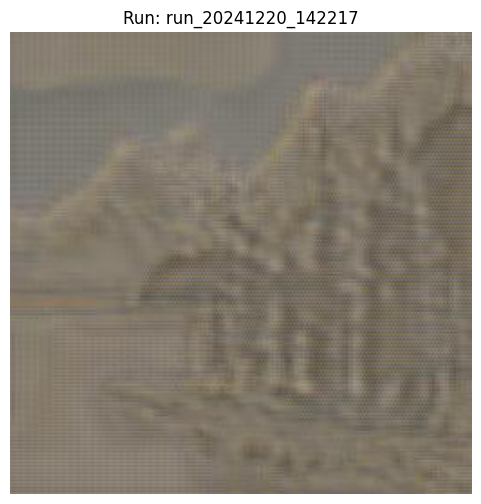

Processing /content/drive/MyDrive/Pipeline_2/sweep_checkpoints/run_20241220_142944/epoch_20.pth...
Generated stylized image saved at: /content/drive/MyDrive/Pipeline_2/generated_images/run_20241220_142944_stylized.jpg


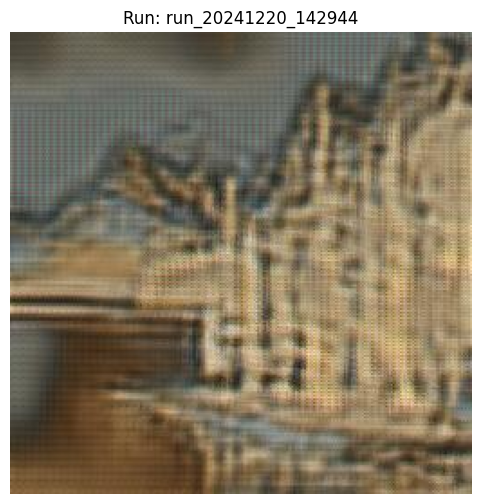

Processing /content/drive/MyDrive/Pipeline_2/sweep_checkpoints/run_20241220_143339/epoch_20.pth...
Generated stylized image saved at: /content/drive/MyDrive/Pipeline_2/generated_images/run_20241220_143339_stylized.jpg


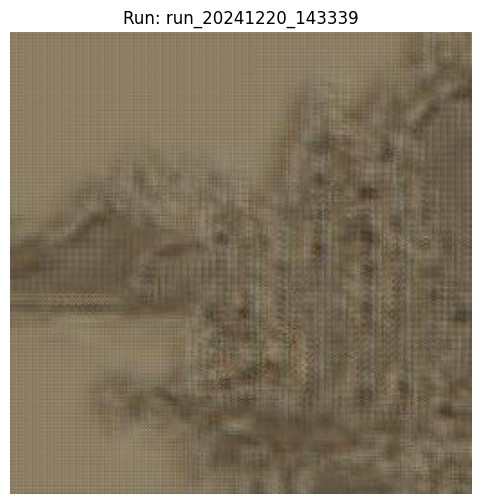

Processing /content/drive/MyDrive/Pipeline_2/sweep_checkpoints/run_20241220_143725/epoch_20.pth...
Generated stylized image saved at: /content/drive/MyDrive/Pipeline_2/generated_images/run_20241220_143725_stylized.jpg


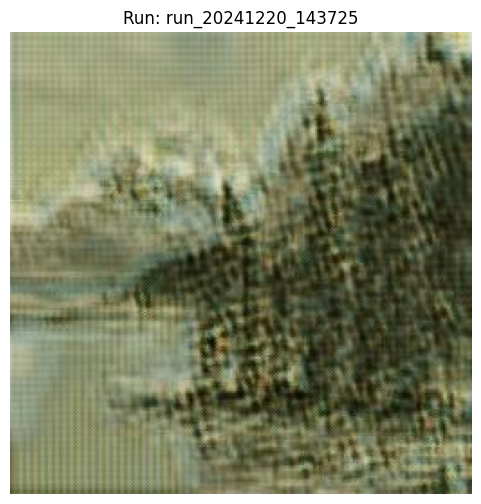

Processing /content/drive/MyDrive/Pipeline_2/sweep_checkpoints/run_20241220_144110/epoch_20.pth...
Generated stylized image saved at: /content/drive/MyDrive/Pipeline_2/generated_images/run_20241220_144110_stylized.jpg


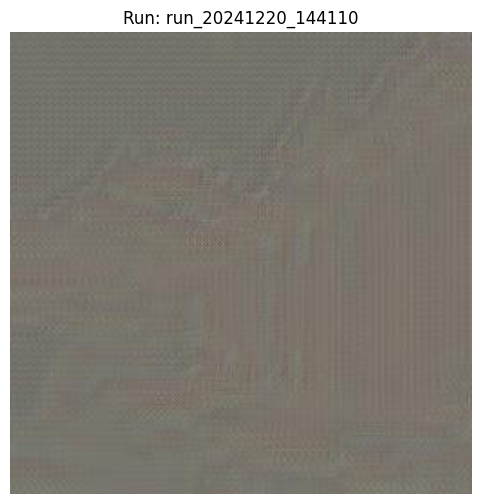

Processing /content/drive/MyDrive/Pipeline_2/sweep_checkpoints/run_20241220_144455/epoch_20.pth...
Generated stylized image saved at: /content/drive/MyDrive/Pipeline_2/generated_images/run_20241220_144455_stylized.jpg


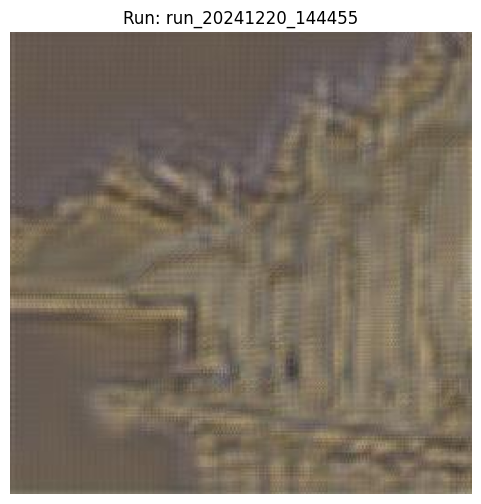

Processing /content/drive/MyDrive/Pipeline_2/sweep_checkpoints/run_20241220_144840/epoch_20.pth...
Generated stylized image saved at: /content/drive/MyDrive/Pipeline_2/generated_images/run_20241220_144840_stylized.jpg


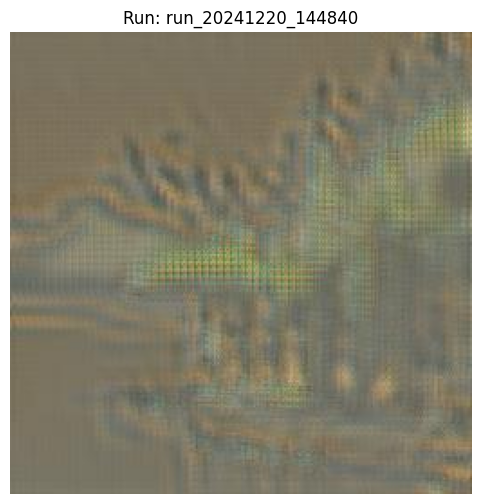

Processing /content/drive/MyDrive/Pipeline_2/sweep_checkpoints/run_20241220_145225/epoch_20.pth...
Generated stylized image saved at: /content/drive/MyDrive/Pipeline_2/generated_images/run_20241220_145225_stylized.jpg


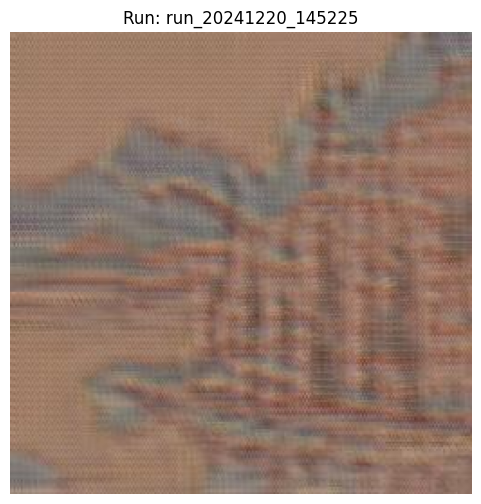

Processing /content/drive/MyDrive/Pipeline_2/sweep_checkpoints/run_20241220_145610/epoch_20.pth...
Generated stylized image saved at: /content/drive/MyDrive/Pipeline_2/generated_images/run_20241220_145610_stylized.jpg


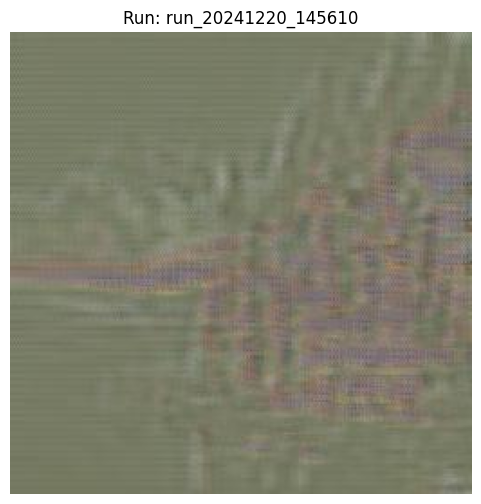

Processing /content/drive/MyDrive/Pipeline_2/sweep_checkpoints/run_20241220_150005/epoch_20.pth...
Generated stylized image saved at: /content/drive/MyDrive/Pipeline_2/generated_images/run_20241220_150005_stylized.jpg


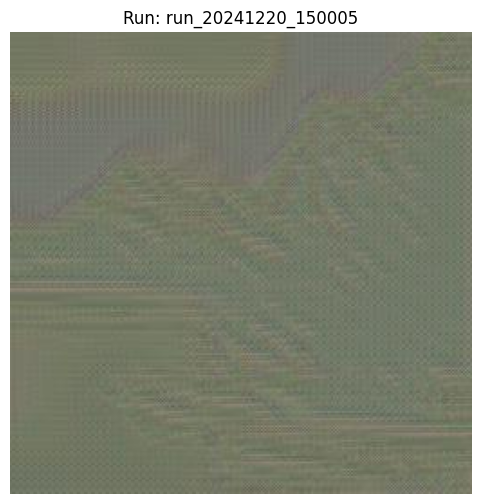

Processing /content/drive/MyDrive/Pipeline_2/sweep_checkpoints/run_20241220_150351/epoch_20.pth...
Generated stylized image saved at: /content/drive/MyDrive/Pipeline_2/generated_images/run_20241220_150351_stylized.jpg


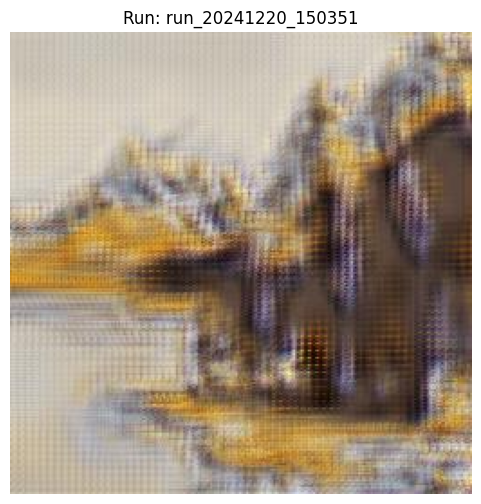

Processing /content/drive/MyDrive/Pipeline_2/sweep_checkpoints/run_20241220_150746/epoch_20.pth...
Generated stylized image saved at: /content/drive/MyDrive/Pipeline_2/generated_images/run_20241220_150746_stylized.jpg


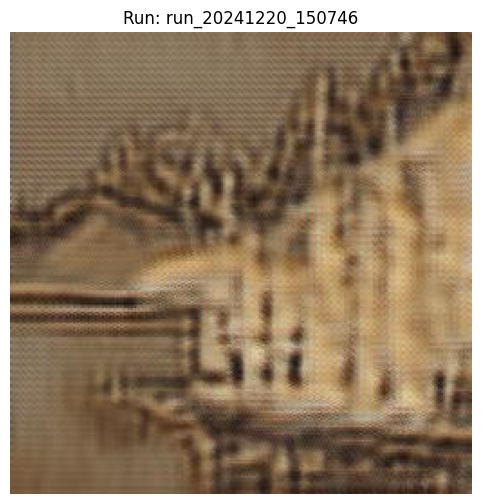

Processing /content/drive/MyDrive/Pipeline_2/sweep_checkpoints/run_20241220_151131/epoch_20.pth...
Generated stylized image saved at: /content/drive/MyDrive/Pipeline_2/generated_images/run_20241220_151131_stylized.jpg


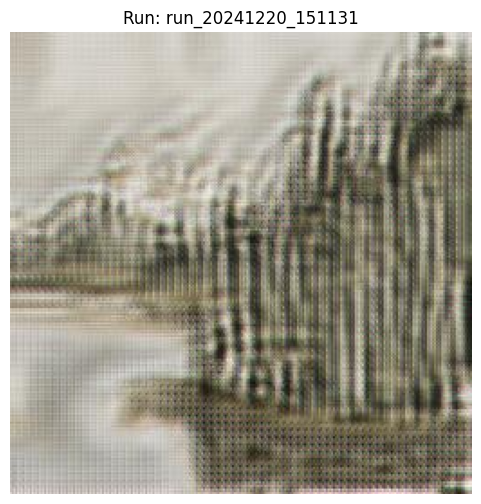

Processing /content/drive/MyDrive/Pipeline_2/sweep_checkpoints/run_20241220_151516/epoch_20.pth...
Generated stylized image saved at: /content/drive/MyDrive/Pipeline_2/generated_images/run_20241220_151516_stylized.jpg


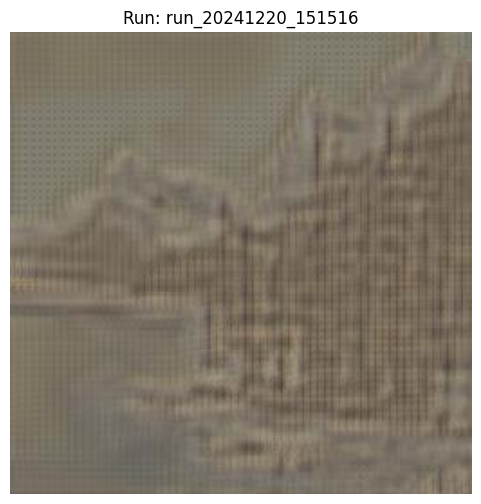

Processing /content/drive/MyDrive/Pipeline_2/sweep_checkpoints/run_20241220_151901/epoch_20.pth...
Generated stylized image saved at: /content/drive/MyDrive/Pipeline_2/generated_images/run_20241220_151901_stylized.jpg


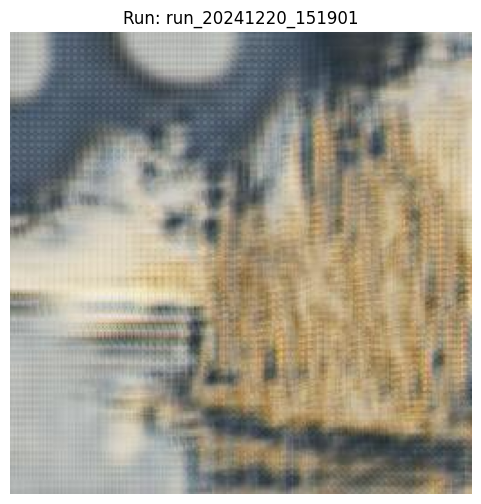

Processing /content/drive/MyDrive/Pipeline_2/sweep_checkpoints/run_20241220_152246/epoch_20.pth...
Generated stylized image saved at: /content/drive/MyDrive/Pipeline_2/generated_images/run_20241220_152246_stylized.jpg


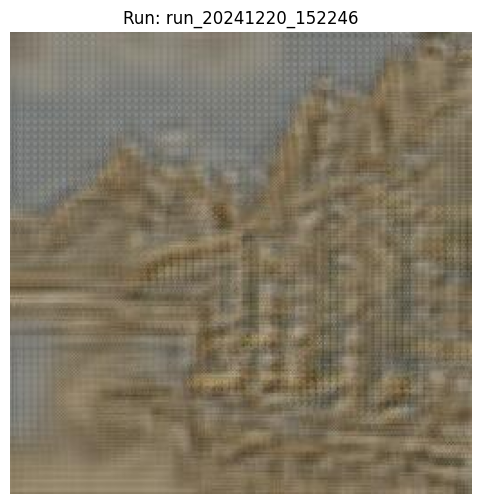

Processing /content/drive/MyDrive/Pipeline_2/sweep_checkpoints/run_20241220_152631/epoch_20.pth...
Generated stylized image saved at: /content/drive/MyDrive/Pipeline_2/generated_images/run_20241220_152631_stylized.jpg


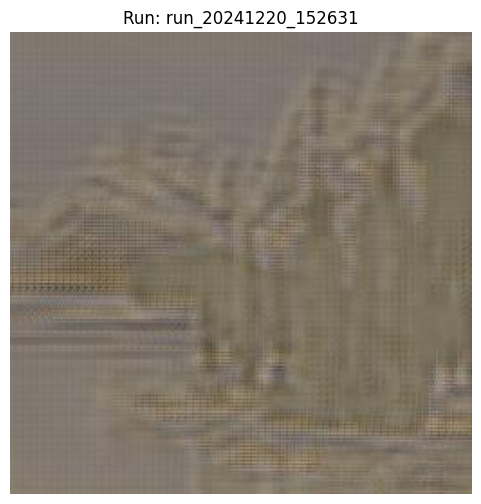

Processing /content/drive/MyDrive/Pipeline_2/sweep_checkpoints/run_20241220_153016/epoch_20.pth...
Generated stylized image saved at: /content/drive/MyDrive/Pipeline_2/generated_images/run_20241220_153016_stylized.jpg


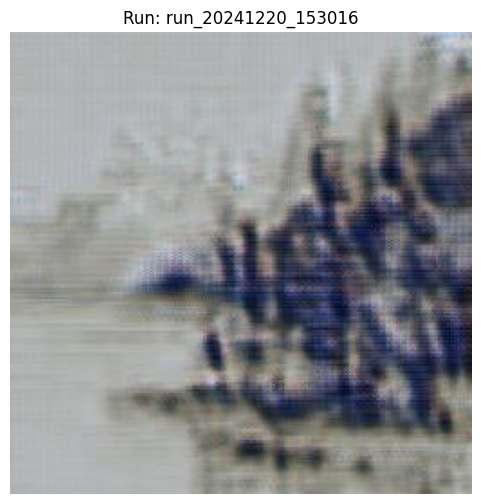

Processing /content/drive/MyDrive/Pipeline_2/sweep_checkpoints/run_20241220_153406/epoch_20.pth...
Generated stylized image saved at: /content/drive/MyDrive/Pipeline_2/generated_images/run_20241220_153406_stylized.jpg


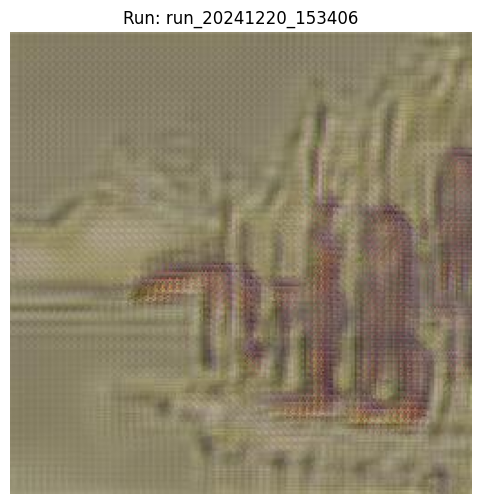

Processing /content/drive/MyDrive/Pipeline_2/sweep_checkpoints/run_20241220_153801/epoch_20.pth...
Generated stylized image saved at: /content/drive/MyDrive/Pipeline_2/generated_images/run_20241220_153801_stylized.jpg


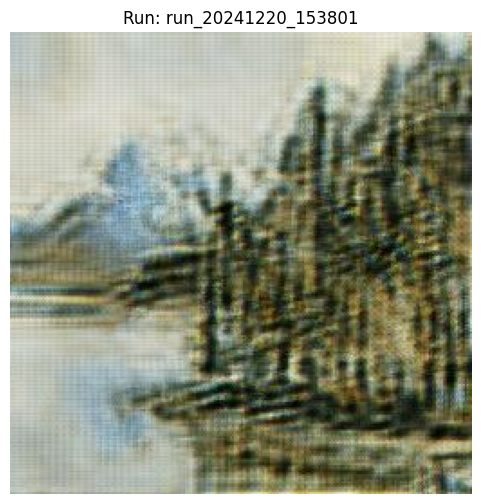

Processing /content/drive/MyDrive/Pipeline_2/sweep_checkpoints/run_20241220_154146/epoch_20.pth...
Generated stylized image saved at: /content/drive/MyDrive/Pipeline_2/generated_images/run_20241220_154146_stylized.jpg


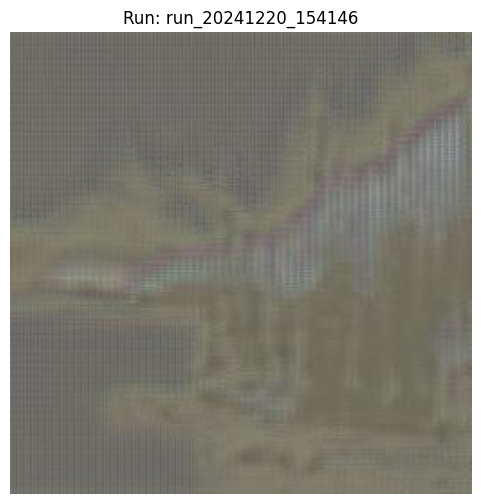

In [ ]:
# Function to generate and save a stylized image
def generate_stylized_image(input_image_path, generator_path, output_image_path):
    # Load the generator model
    generator = load_generator(generator_path)
    # Preprocess the input image
    input_tensor = preprocess_image(input_image_path)
    # Generate the stylized image
    with torch.no_grad():
        output_tensor = generator(input_tensor)
    # Postprocess and save the output image
    postprocess_and_save(output_tensor, output_image_path)
    print(f"Generated stylized image saved at: {output_image_path}")

# Function to process all runs and display/save images
def process_and_display_runs(input_image_path, runs_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    # Loop through all subdirectories in the runs directory
    for run_dir in sorted(os.listdir(runs_dir)):
        run_path = os.path.join(runs_dir, run_dir)
        epoch_20_path = os.path.join(run_path, "epoch_20.pth")

        # Check if epoch_20.pth exists
        if os.path.exists(epoch_20_path):
            print(f"Processing {epoch_20_path}...")
            output_image_path = os.path.join(output_dir, f"{run_dir}_stylized.jpg")

            # Generate stylized image
            try:
                generate_stylized_image(input_image_path, epoch_20_path, output_image_path)

                # Display the image with the run name
                output_image = Image.open(output_image_path)
                plt.figure(figsize=(6, 6))
                plt.imshow(output_image)
                plt.axis("off")
                plt.title(f"Run: {run_dir}", fontsize=12)
                plt.show()

            except Exception as e:
                print(f"Error processing {epoch_20_path}: {e}")
        else:
            print(f"Skipping {run_dir}: epoch_20.pth not found.")

# Paths for Input, Runs Directory, and Output Directory
input_image_path = "/content/download.jpeg"  # Input image path
runs_dir = "/content/drive/MyDrive/Pipeline_2/sweep_checkpoints"
output_dir = "/content/drive/MyDrive/Pipeline_2/generated_images"

# Process all runs and generate outputs
process_and_display_runs(input_image_path, runs_dir, output_dir)

## **Training with lambda Cycle=10 and Lambda Identity=1**

Epoch [1/20], Generator Loss: 8.0994, Discriminator Loss: 0.1586
Epoch [2/20], Generator Loss: 6.9916, Discriminator Loss: 0.1012
Epoch [3/20], Generator Loss: 6.7434, Discriminator Loss: 0.0823
Epoch [4/20], Generator Loss: 6.5232, Discriminator Loss: 0.0781
Epoch [5/20], Generator Loss: 6.3496, Discriminator Loss: 0.0720
Epoch [6/20], Generator Loss: 6.2668, Discriminator Loss: 0.0619
Epoch [7/20], Generator Loss: 6.1758, Discriminator Loss: 0.0595
Epoch [8/20], Generator Loss: 6.0397, Discriminator Loss: 0.0706
Epoch [9/20], Generator Loss: 5.9701, Discriminator Loss: 0.0586
Epoch [10/20], Generator Loss: 5.9779, Discriminator Loss: 0.0549
Epoch [11/20], Generator Loss: 5.9043, Discriminator Loss: 0.0542
Epoch [12/20], Generator Loss: 5.9907, Discriminator Loss: 0.0584
Epoch [13/20], Generator Loss: 6.0190, Discriminator Loss: 0.0425
Epoch [14/20], Generator Loss: 5.9312, Discriminator Loss: 0.0399
Epoch [15/20], Generator Loss: 5.9353, Discriminator Loss: 0.0340
Epoch [16/20], Gene

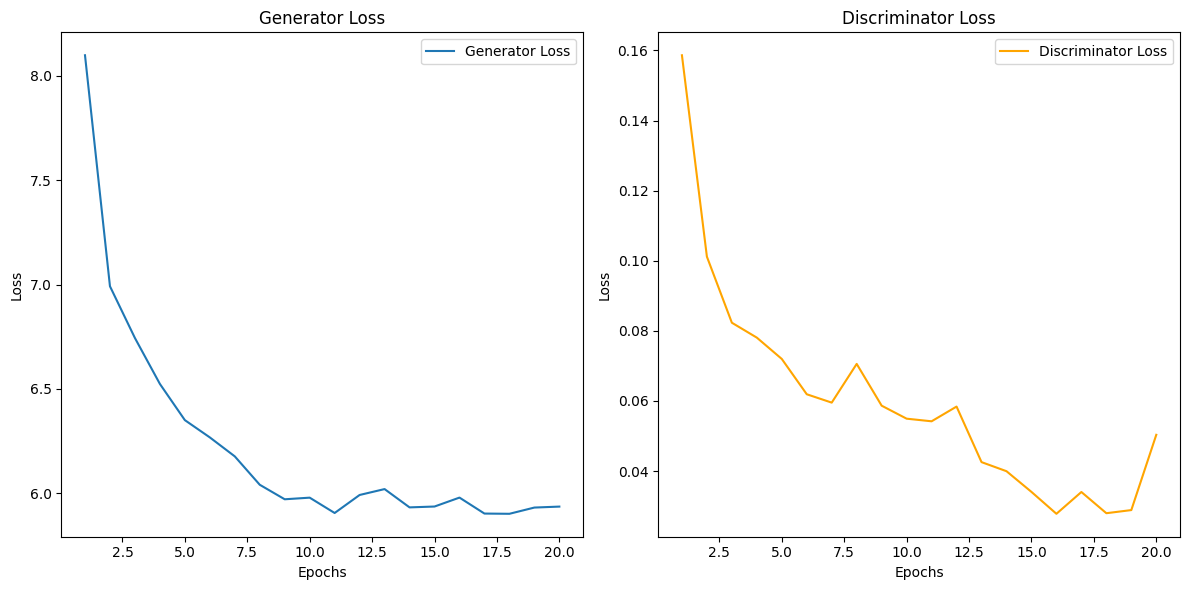

In [ ]:
train_cycle_gan_model(
    data_A_dir = "/content/drive/MyDrive/Pipeline_2/clustered_images/cluster_2",
    data_B_dir = "/content/drive/MyDrive/Pipeline_2/clustered_images_VanGogh/cluster_4",
    batch_size = 8,
    epochs = 20,
    generator_lr = 0.0005,
    discriminator_lr = 0.00005,
    lambda_cycle = 10.0,
    lambda_identity = 1.0,
    checkpoint_dir = "/content/drive/MyDrive/Pipeline_2/CycleGAN_Tuned_10_1_Checkpoints"
)

Loading from checkpoint...


<ipython-input-7-25cebbaad5ae>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(checkpoint_dir, "last_checkpoint.pth"))


Resuming training from epoch 140...
Epoch [141/150], Generator Loss: 4.9412, Discriminator Loss: 0.0000
Epoch [142/150], Generator Loss: 4.9371, Discriminator Loss: 0.0000
Epoch [143/150], Generator Loss: 4.9212, Discriminator Loss: 0.0217
Epoch [144/150], Generator Loss: 4.9024, Discriminator Loss: 0.0044
Epoch [145/150], Generator Loss: 4.9199, Discriminator Loss: 0.0007
Epoch [146/150], Generator Loss: 4.9083, Discriminator Loss: 0.0004
Epoch [147/150], Generator Loss: 4.9294, Discriminator Loss: 0.0003
Epoch [148/150], Generator Loss: 4.9383, Discriminator Loss: 0.0001
Epoch [149/150], Generator Loss: 4.9296, Discriminator Loss: 0.0001
Epoch [150/150], Generator Loss: 4.9036, Discriminator Loss: 0.0000


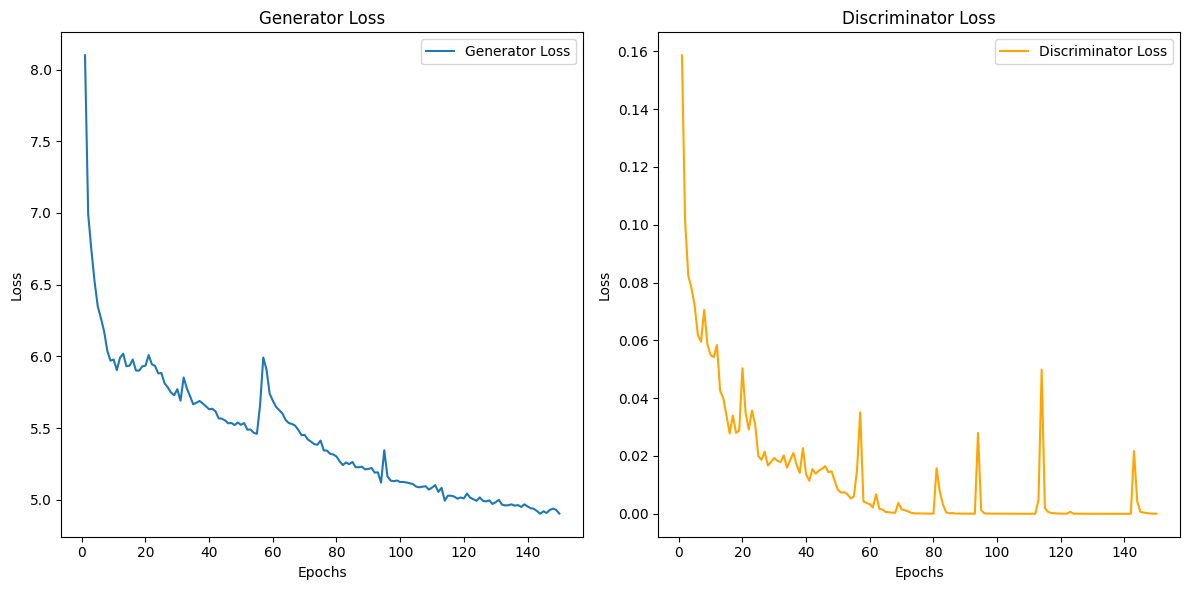

In [ ]:
train_cycle_gan_model(
    data_A_dir = "/content/drive/MyDrive/Pipeline_2/clustered_images/cluster_2",
    data_B_dir = "/content/drive/MyDrive/Pipeline_2/clustered_images_VanGogh/cluster_4",
    batch_size = 8,
    epochs = 150,
    generator_lr = 0.0005,
    discriminator_lr = 0.00005,
    lambda_cycle = 10.0,
    lambda_identity = 1.0,
    checkpoint_dir = "/content/drive/MyDrive/Pipeline_2/CycleGAN_Tuned_10_1_Checkpoints"
)

<ipython-input-13-613160fd4b6f>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(generator_path, map_location=device)  # Load checkpoint


Generated stylized image saved at: stylized_image.jpg


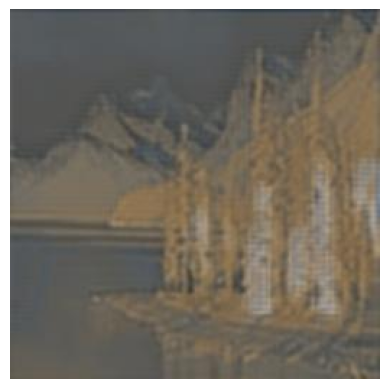

In [ ]:
# After 150 epochs
input_image_path = "/content/download.jpeg"
generator_path = "/content/drive/MyDrive/Pipeline_2/CycleGAN_Tuned_10_1_Checkpoints/last_checkpoint.pth"
output_image_path = "stylized_image.jpg"

# Generate and visualize the stylized image
generate_stylized_image(input_image_path, generator_path, output_image_path)

# Display the result
output_image = Image.open(output_image_path)
plt.imshow(output_image)
plt.axis("off")
plt.show()

## **Training with lambda Cycle=10 and Lambda Identity=5**

Loading from checkpoint...
Resuming training from epoch 90...


<ipython-input-7-25cebbaad5ae>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(checkpoint_dir, "last_checkpoint.pth"))


Epoch [91/150], Generator Loss: 8.5945, Discriminator Loss: 0.0000
Epoch [92/150], Generator Loss: 8.6069, Discriminator Loss: 0.0000
Epoch [93/150], Generator Loss: 8.5873, Discriminator Loss: 0.0000
Epoch [94/150], Generator Loss: 8.5667, Discriminator Loss: 0.0000
Epoch [95/150], Generator Loss: 8.5586, Discriminator Loss: 0.0000
Epoch [96/150], Generator Loss: 8.5613, Discriminator Loss: 0.0000
Epoch [97/150], Generator Loss: 8.5827, Discriminator Loss: 0.0000
Epoch [98/150], Generator Loss: 8.5470, Discriminator Loss: 0.0000
Epoch [99/150], Generator Loss: 8.5361, Discriminator Loss: 0.0000
Epoch [100/150], Generator Loss: 8.5354, Discriminator Loss: 0.0000
Epoch [101/150], Generator Loss: 8.5296, Discriminator Loss: 0.0000
Epoch [102/150], Generator Loss: 8.6214, Discriminator Loss: 0.0000
Epoch [103/150], Generator Loss: 8.5103, Discriminator Loss: 0.0000
Epoch [104/150], Generator Loss: 8.5021, Discriminator Loss: 0.0000
Epoch [105/150], Generator Loss: 8.5182, Discriminator Lo

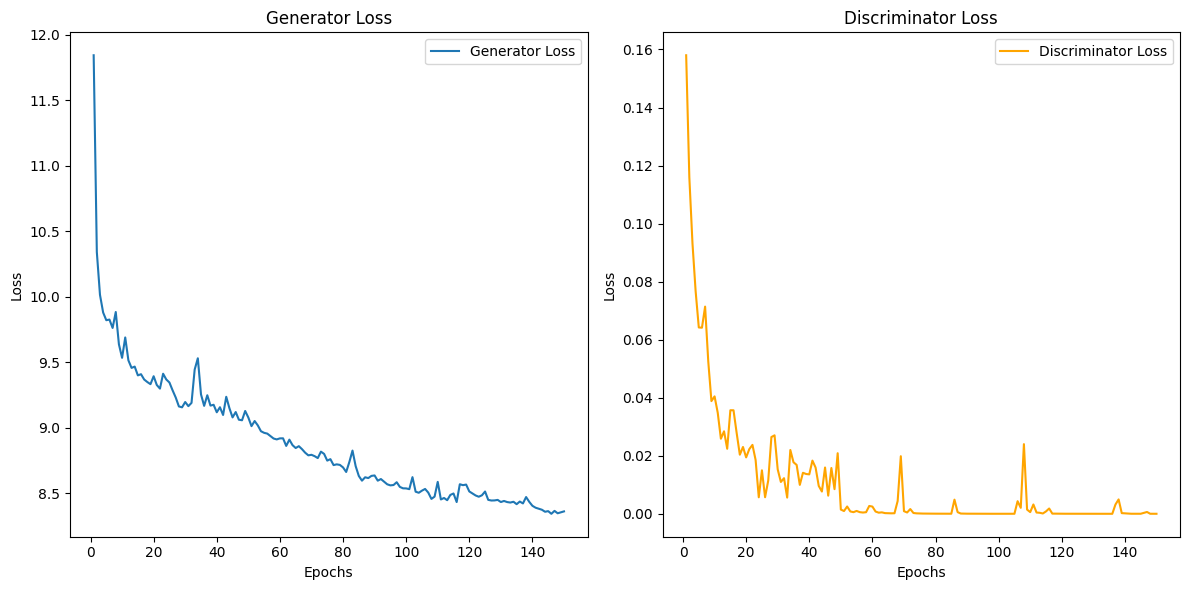

In [ ]:
# Traing with increasing the identity loss
train_cycle_gan_model(
    data_A_dir = "/content/drive/MyDrive/Pipeline_2/clustered_images/cluster_2",
    data_B_dir = "/content/drive/MyDrive/Pipeline_2/clustered_images_VanGogh/cluster_4",
    batch_size = 8,
    epochs = 150,
    generator_lr = 0.0005,
    discriminator_lr = 0.00005,
    lambda_cycle = 10.0,
    lambda_identity = 5.0,
    checkpoint_dir = "/content/drive/MyDrive/Pipeline_2/CycleGAN_Tuned_10_5_Checkpoints"
)

Generated stylized image saved at: stylized_image.jpg


<ipython-input-16-613160fd4b6f>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(generator_path, map_location=device)  # Load checkpoint


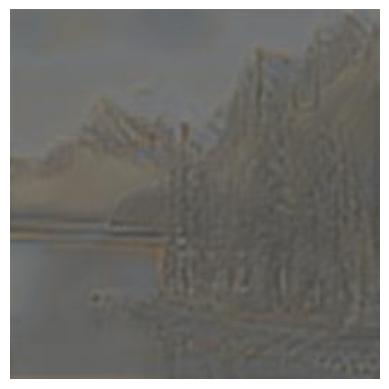

In [ ]:
# After 90 epochs
input_image_path = "/content/download.jpeg"
generator_path = "/content/drive/MyDrive/Pipeline_2/CycleGAN_Tuned_10_5_Checkpoints/generator_A2B_epoch100.pth"
output_image_path = "stylized_image.jpg"

# Generate and visualize the stylized image
generate_stylized_image(input_image_path, generator_path, output_image_path)

# Display the result
output_image = Image.open(output_image_path)
plt.imshow(output_image)
plt.axis("off")
plt.show()

<ipython-input-16-613160fd4b6f>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(generator_path, map_location=device)  # Load checkpoint


Generated stylized image saved at: stylized_image.jpg


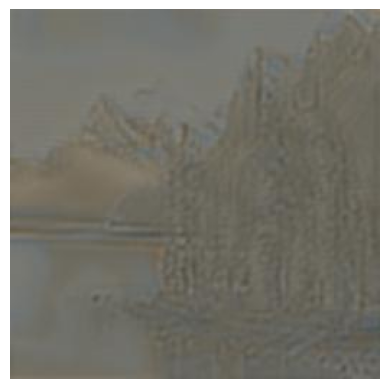

In [ ]:
# After 150 epochs
input_image_path = "/content/download.jpeg"
generator_path = "/content/drive/MyDrive/Pipeline_2/CycleGAN_Tuned_10_5_Checkpoints/last_checkpoint.pth"
output_image_path = "stylized_image.jpg"

# Generate and visualize the stylized image
generate_stylized_image(input_image_path, generator_path, output_image_path)

# Display the result
output_image = Image.open(output_image_path)
plt.imshow(output_image)
plt.axis("off")
plt.show()